In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab \Notebooks/microscopy_self_supervised_learning/

/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning


Imports

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.manifold import TSNE
import umap

Paths & Metadata

In [5]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/microscopy_self_supervised_learning/data/raw"
RESULTS_DIR = "results/figures"
os.makedirs(RESULTS_DIR, exist_ok=True)

metadata = pd.read_csv("data/processed/metadata_with_moa.csv")
subset = metadata.sample(n=min(2000, len(metadata)), random_state=42)

Image Loader

In [6]:
def fix_path(pathname):
    return pathname.split("/")[-1]

def load_3channel_image(row):
    paths = [
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_DAPI"]), row["Image_FileName_DAPI"]),
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_Tubulin"]), row["Image_FileName_Tubulin"]),
        os.path.join(BASE_DIR, fix_path(row["Image_PathName_Actin"]), row["Image_FileName_Actin"])
    ]

    channels = []
    for p in paths:
        img = tiff.imread(p).astype(np.float32)

        # global normalization for uint16
        img = img / 65535.0

        img = cv2.resize(img, (128,128))
        channels.append(img)

    img_stack = np.stack(channels, axis=0)
    return img_stack

Augmentations (SimCLR)

In [7]:
def augment(x):
    if np.random.rand() < 0.5:
        x = np.flip(x, axis=2).copy()
    if np.random.rand() < 0.5:
        x = np.flip(x, axis=1).copy()

    noise = np.random.normal(0, 0.02, x.shape)
    x = x + noise
    x = np.clip(x, 0, 1)
    return x

Dataset

In [8]:
class MicroscopySSLDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = load_3channel_image(row)

        x1 = augment(img)
        x2 = augment(img)

        return torch.tensor(x1, dtype=torch.float32), torch.tensor(x2, dtype=torch.float32)

DataLoader

In [9]:
dataset = MicroscopySSLDataset(subset)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Encoder Network

In [10]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*16*16, embedding_dim)
        )

    def forward(self, x):
        return self.net(x)

Projection Head

In [11]:
class SimCLR(nn.Module):
    def __init__(self, embedding_dim=64):
        super().__init__()
        self.encoder = Encoder(embedding_dim)
        self.projector = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        z = self.encoder(x)
        p = self.projector(z)
        return z, p

NT-Xent Loss

In [14]:
def nt_xent_loss(z1, z2, temperature=0.5):
    B = z1.size(0)

    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    z = torch.cat([z1, z2], dim=0)   # (2B, D)

    sim = torch.matmul(z, z.T) / temperature  # (2B, 2B)

    # mask self-similarity
    mask = torch.eye(2*B, device=z.device).bool()
    sim = sim.masked_fill(mask, -9e15)

    # positives: i-th sample matches i+B and vice versa
    targets = torch.arange(B, device=z.device)
    targets = torch.cat([targets + B, targets], dim=0)  # (2B,)

    loss = F.cross_entropy(sim, targets)
    return loss

Train Loop

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimCLR(embedding_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for x1, x2 in loop:
        x1 = x1.to(device)
        x2 = x2.to(device)

        z1, p1 = model(x1)
        z2, p2 = model(x2)

        loss = nt_xent_loss(p1, p2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader)
    losses.append(epoch_loss)
    print("Epoch loss:", epoch_loss)

Epoch 1: 100%|██████████| 10/10 [08:08<00:00, 48.81s/it, loss=3.13]


Epoch loss: 3.9848647356033324


Epoch 2: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it, loss=2.77]


Epoch loss: 3.985714292526245


Epoch 3: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it, loss=2.21]


Epoch loss: 3.457026410102844


Epoch 4: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it, loss=2.02]


Epoch loss: 3.1081435680389404


Epoch 5: 100%|██████████| 10/10 [00:19<00:00,  1.98s/it, loss=2.15]


Epoch loss: 3.0671452045440675


Epoch 6: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it, loss=1.98]


Epoch loss: 2.9360148787498472


Epoch 7: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it, loss=1.92]


Epoch loss: 2.8660903573036194


Epoch 8: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it, loss=1.86]


Epoch loss: 2.906249630451202


Epoch 9: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it, loss=1.89]


Epoch loss: 2.8320416808128357


Epoch 10: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it, loss=1.94]

Epoch loss: 2.7345288038253783


Plot Training Loss

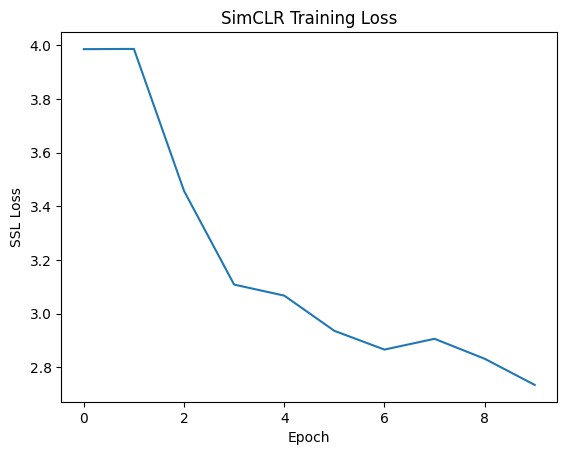

In [16]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("SSL Loss")
plt.title("SimCLR Training Loss")
plt.savefig(f"{RESULTS_DIR}/ssl_loss.png")
plt.show()

Extract Embeddings

In [17]:
embeddings = []
labels = []

model.eval()

for _, row in tqdm(subset.iterrows(), total=len(subset)):
    img = load_3channel_image(row)
    x = torch.tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        z, _ = model(x)

    embeddings.append(z.cpu().numpy().squeeze())
    labels.append(row["moa"])

embeddings = np.array(embeddings)
labels = np.array(labels)

100%|██████████| 300/300 [00:21<00:00, 13.92it/s]


UMAP

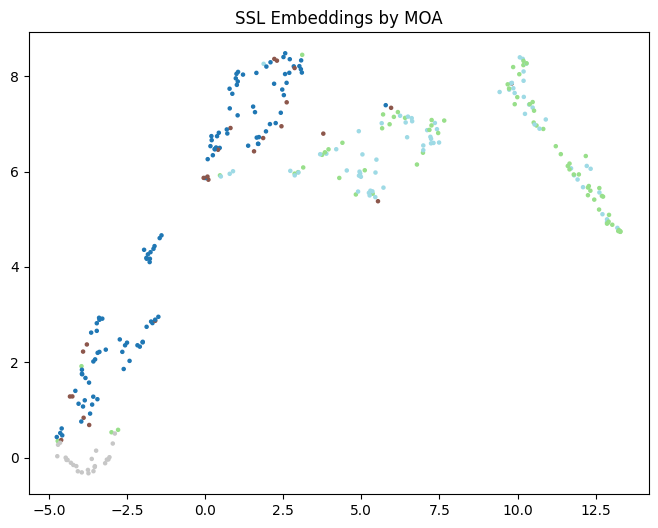

In [18]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
umap_emb = reducer.fit_transform(embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(umap_emb[:,0], umap_emb[:,1], c=pd.factorize(labels)[0], cmap="tab20", s=5)
plt.title("SSL Embeddings by MOA")
plt.savefig(f"{RESULTS_DIR}/ssl_umap.png")
plt.show()

Show Augmentations (sanity check)

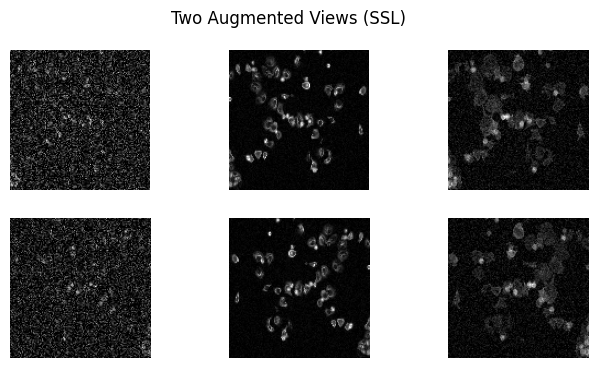

In [19]:
x1, x2 = dataset[0]

fig, axes = plt.subplots(2,3, figsize=(8,4))
for i in range(3):
    axes[0,i].imshow(x1[i], cmap="gray")
    axes[1,i].imshow(x2[i], cmap="gray")
    axes[0,i].axis("off")
    axes[1,i].axis("off")

plt.suptitle("Two Augmented Views (SSL)")
plt.show()